# 데이터 마이닝 과제 

## Unbalance Data Training의 결과 성능 비교 코드 정리

In [1]:
# 필요한 패키지 import 

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib import rc # 한글 그래픽 처리
import seaborn as sns # r에서 ggplot이라 생각하면됨. 쓸때 한글처리 주의.
%matplotlib inline 
plt.rc('font', family='Malgun Gothic') # 한글의 폰트를 맑은고딕 사용
plt.rc('axes', unicode_minus=False)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# data Loading

data = pd.read_csv('WSDM_train_full_features.csv',engine='python')
data.head()

,target,user_idx,song_idx,ssn_idx,sst_idx,st_idx,song_length,genr_idx,art_idx,com_idx,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,1,0,0,0,0,0,206471,7,1877,7450,...,0,2,0,0,0,0,0,1,215,1140
1,1,1,1,1,1,1,284584,18,92,2,...,0,1,0,0,0,0,0,0,1,303616
2,1,1,2,1,1,1,225396,18,527,100234,...,0,1,0,0,0,0,0,1,4,289
3,1,1,3,1,1,1,255512,229,89592,193180,...,0,1,0,0,0,0,0,0,1,1
4,1,0,4,0,0,0,187802,13,195,137,...,0,3,0,0,0,0,0,1,412,427


In [3]:
# 워본 데이터의 비율 확인 

data['target'].value_counts()

1    3714656
0    3662762
Name: target, dtype: int64

In [4]:
# 데이터의 양이 많아 데이터를 축소시키기 위해 사용 
from sklearn.model_selection import train_test_split
data,data_drop = train_test_split(data,test_size=0.5,random_state=0)
del data_drop # 삭제해서 용량 살리기 위해.

In [5]:
# 축소결과 비율 비슷하게 유지됨 
data['target'].value_counts()

1    1858531
0    1830178
Name: target, dtype: int64

In [6]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

1830178

## Unblance Data 만들기 

In [7]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:] # 1: 999
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:] # 1: 99## unblance data 만들기 
#target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/9)*len(target0)),:] # 1:9

In [8]:
# 데이터 합치기 

data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
#data_0_1 = pd.concat([target1,target0_1])

In [9]:
X = data0_001.iloc[:,1:]
y = data0_001.iloc[:,0]

In [10]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

## Sampling 기법 import

In [11]:
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.ensemble import *
from imblearn.combine import *

In [16]:
# Over sampling model  
# ratio
sampling = []
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline1'))
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline2'))
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(RandomOverSampler(random_state=0))
sampling.append(ADASYN(random_state=0))

## 성능 비교에 활용할 모델은 RandomForestClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score,accuracy_score

In [18]:
roc_auc_10 = []
accuracy_10 = []
f1_10 = []
preci_10 = []
recall_10 = []

In [19]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_10.append(roc_auc_score(y_test,y_proba))
    accuracy_10.append(accuracy_score(y_test,y_pred))
    f1_10.append(f1_score(y_test,y_pred))
    preci_10.append(precision_score(y_test,y_pred))
    recall_10.append(recall_score(y_test,y_pred))

In [20]:
df_1 = pd.DataFrame({'modelname':['SMOTE1','SMOTE2','SMOTE','ROS','ADASYN'],
                  'roc_auc':roc_auc_10,'accuracy':accuracy_10,'f1_score':f1_10,'precision':preci_10,
                  'recall_score':recall_10})
df_1

,modelname,roc_auc,accuracy,f1_score,precision,recall_score
0,SMOTE1,0.500079,0.998988,0.000000,0.000000,0.000000
1,SMOTE2,0.501455,0.998983,0.000000,0.000000,0.000000
2,SMOTE,0.522748,0.998770,0.005882,0.015038,0.003656
3,ROS,0.504697,0.998970,0.000000,0.000000,0.000000
4,ADASYN,0.522862,0.998816,0.000000,0.000000,0.000000


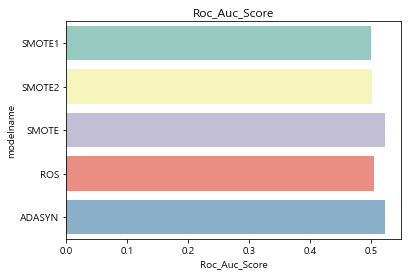

In [21]:
g = sns.barplot("roc_auc","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

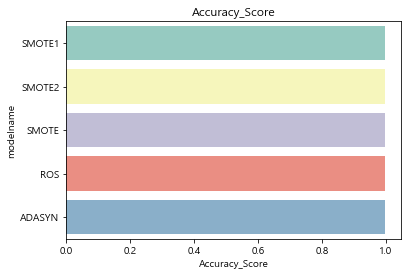

In [22]:
g = sns.barplot("accuracy","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

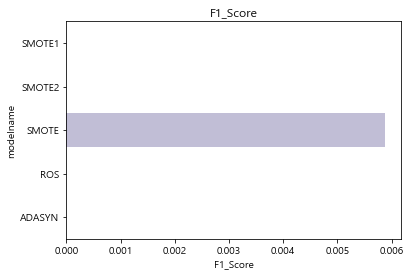

In [23]:
g = sns.barplot("f1_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

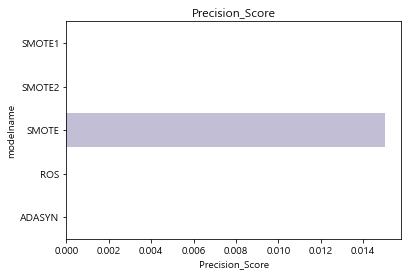

In [24]:
g = sns.barplot("precision","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

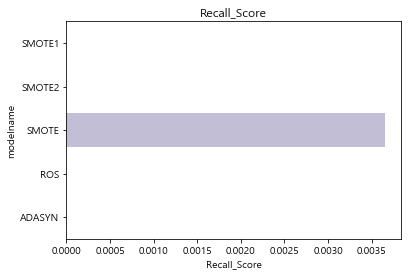

In [25]:
g = sns.barplot("recall_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

In [26]:
# Over sampling model  
# ratio
sampling = []
sampling.append(RandomOverSampler(random_state=0))
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline1'))
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline2'))
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(ADASYN(random_state=0))
#kind='borderline1', kind='borderline2'
# Under sampling model 
#sampling.append(RandomUnderSampler(random_state=0))

In [28]:
acu_mean = []
acu_sd = []
roc_mean = []
roc_sd = []
f1_mean = []
f1_sd = []
recall_mean = []
recall_sd = []
preci_mean = []
preci_sd = []
predict  = []
proba = []
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_trains , y_trains = sampling[i].fit_sample(X_train,y_train)
    scores_accu = cross_val_score(model, X_trains, y_trains, cv = 3,scoring='accuracy',n_jobs = -1)
    scores_roc_auc = cross_val_score(model, X_trains, y_trains, cv = 3,scoring='roc_auc',n_jobs = -1)
    scores_f1 = cross_val_score(model, X_trains, y_trains, cv = 3,scoring='f1',n_jobs = -1)
    scores_recall = cross_val_score(model, X_trains, y_trains, cv = 3,scoring='recall',n_jobs = -1)
    scores_precision = cross_val_score(model, X_trains, y_trains, cv = 3,scoring='precision',n_jobs = -1)
    acu_mean.append(scores_accu.mean())
    acu_sd.append(scores_accu.std())
    roc_mean.append(scores_roc_auc.mean())
    roc_sd.append(scores_roc_auc.std())
    f1_mean.append(scores_f1.mean())
    f1_sd.append(scores_f1.std())
    recall_mean.append(scores_recall.mean())
    recall_sd.append(scores_recall.std())
    preci_mean.append(scores_precision.mean())
    preci_mean.append(scores_precision.std())
    model.fit(X_trains,y_trains)
    predict.append(model.predict(X_test))
    proba.append(model.predict_proba(X_test))
# pricision이 제대로 안나와서 전처리 따로 
pri_sd = []
pri = []
for i in range(5):
    pri_sd.append(preci_mean[1+2*i])
    pri.append(preci_mean[2*i])
predict_acc = []
predict_f1 = []
predict_recall = []
predict_roc = []
predict_pri = []
for i in range(len(predict)):
    predict_acc.append(accuracy_score(y_test,predict[i]))
    predict_roc.append(roc_auc_score(y_test,proba[i][:,1]))
    predict_f1.append(f1_score(y_test,predict[i]))
    predict_recall.append(recall_score(y_test,predict[i]))
    predict_pri.append(precision_score(y_test,predict[i]))   

ValueError: bad input shape (549603, 2)

In [30]:
cv_res = pd.DataFrame({'Scoring':['SMOTE1','SMOTE2','SMOTE','ROS','ADASYN'],
                       'AMean':acu_mean,'AStd':acu_sd,
                      'roc_auc_mean':roc_mean,'roc_auc_std':roc_sd,'f1_mean':f1_mean,
                      'f1_sd':f1_sd,'recall_mean':recall_mean,'recall_sd':recall_sd,
                      'preci_mean':pri,'preci_sd':pri_sd,'test_accu':predict_acc,
                      'test_f1':predict_f1,'test_recall':predict_recall,'test_pre':predict_pri,
                      'test_roc_auc':predict_roc})
cv_res

,Scoring,AMean,AStd,roc_auc_mean,roc_auc_std,f1_mean,f1_sd,recall_mean,recall_sd,preci_mean,preci_sd,test_accu,test_f1,test_recall,test_pre,test_roc_auc
0,SMOTE1,0.999972,0.000001,0.999999,9.559932e-07,0.999972,0.000001,1.000000,0.000000,0.999945,0.000002,0.998970,0.000000,0.000000,0.000000,0.504697
1,SMOTE2,0.999494,0.000696,0.999514,6.870355e-04,0.999493,0.000697,0.999008,0.001398,0.999980,0.000006,0.998988,0.000000,0.000000,0.000000,0.500079
2,SMOTE,0.999489,0.000701,0.999517,6.835468e-04,0.999488,0.000702,0.999003,0.001406,0.999975,0.000005,0.998983,0.000000,0.000000,0.000000,0.501455
3,ROS,0.999309,0.000516,0.999882,1.477292e-04,0.999309,0.000517,0.999042,0.001070,0.999576,0.000038,0.998770,0.005882,0.003656,0.015038,0.522748
4,ADASYN,0.885720,0.005448,0.984813,3.374008e-03,0.870953,0.006930,0.771726,0.010914,0.999574,0.000023,0.998816,0.000000,0.000000,0.000000,0.522862


In [31]:
oversampling = cv_res
oversampling

,Scoring,AMean,AStd,roc_auc_mean,roc_auc_std,f1_mean,f1_sd,recall_mean,recall_sd,preci_mean,preci_sd,test_accu,test_f1,test_recall,test_pre,test_roc_auc
0,SMOTE1,0.999972,0.000001,0.999999,9.559932e-07,0.999972,0.000001,1.000000,0.000000,0.999945,0.000002,0.998970,0.000000,0.000000,0.000000,0.504697
1,SMOTE2,0.999494,0.000696,0.999514,6.870355e-04,0.999493,0.000697,0.999008,0.001398,0.999980,0.000006,0.998988,0.000000,0.000000,0.000000,0.500079
2,SMOTE,0.999489,0.000701,0.999517,6.835468e-04,0.999488,0.000702,0.999003,0.001406,0.999975,0.000005,0.998983,0.000000,0.000000,0.000000,0.501455
3,ROS,0.999309,0.000516,0.999882,1.477292e-04,0.999309,0.000517,0.999042,0.001070,0.999576,0.000038,0.998770,0.005882,0.003656,0.015038,0.522748
4,ADASYN,0.885720,0.005448,0.984813,3.374008e-03,0.870953,0.006930,0.771726,0.010914,0.999574,0.000023,0.998816,0.000000,0.000000,0.000000,0.522862


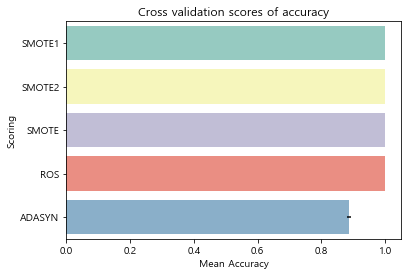

In [37]:
g = sns.barplot("AMean","Scoring",data = oversampling, palette="Set3",orient = "h",**{'xerr':acu_sd})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores of accuracy")

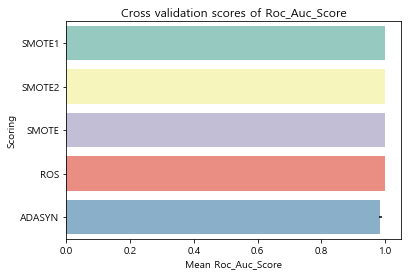

In [38]:
g = sns.barplot("roc_auc_mean","Scoring",data = oversampling, palette="Set3",orient = "h",**{'xerr':acu_sd})
g.set_xlabel("Mean Roc_Auc_Score")
g = g.set_title("Cross validation scores of Roc_Auc_Score")

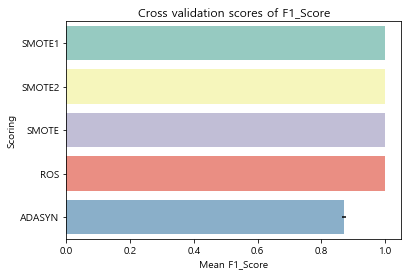

In [39]:
g = sns.barplot("f1_mean","Scoring",data = oversampling, palette="Set3",orient = "h",**{'xerr':acu_sd})
g.set_xlabel("Mean F1_Score")
g = g.set_title("Cross validation scores of F1_Score")

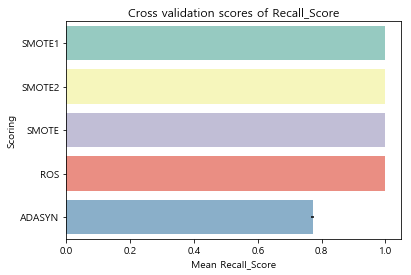

In [40]:
g = sns.barplot('recall_mean',"Scoring",data = oversampling, palette="Set3",orient = "h",**{'xerr':acu_sd})
g.set_xlabel("Mean Recall_Score")
g = g.set_title("Cross validation scores of Recall_Score")

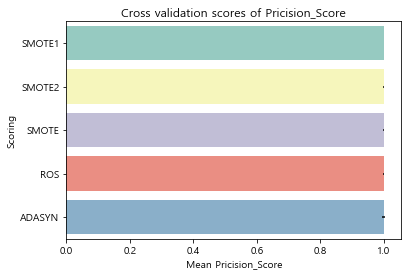

In [41]:
g = sns.barplot('preci_mean',"Scoring",data = oversampling, palette="Set3",orient = "h",**{'xerr':acu_sd})
g.set_xlabel("Mean Pricision_Score")
g = g.set_title("Cross validation scores of Pricision_Score")

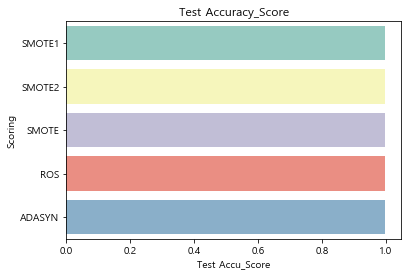

In [42]:
g = sns.barplot('test_accu',"Scoring",data = oversampling, palette="Set3",orient = "h")
g.set_xlabel("Test Accu_Score")
g = g.set_title("Test Accuracy_Score")

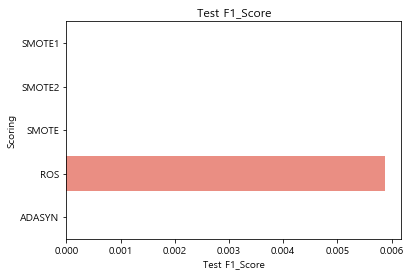

In [43]:
g = sns.barplot('test_f1',"Scoring",data = oversampling, palette="Set3",orient = "h")
g.set_xlabel("Test F1_Score")
g = g.set_title("Test F1_Score")

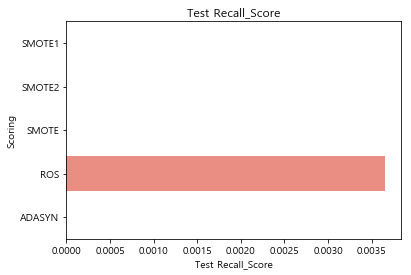

In [44]:
g = sns.barplot('test_recall',"Scoring",data = oversampling, palette="Set3",orient = "h")
g.set_xlabel("Test Recall_Score")
g = g.set_title("Test Recall_Score")

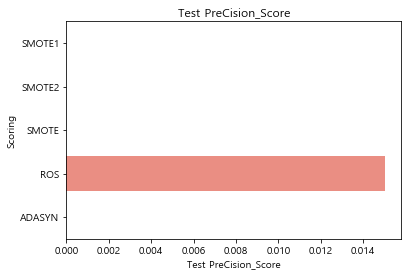

In [45]:
g = sns.barplot('test_pre',"Scoring",data = oversampling, palette="Set3",orient = "h")
g.set_xlabel("Test PreCision_Score")
g = g.set_title("Test PreCision_Score")

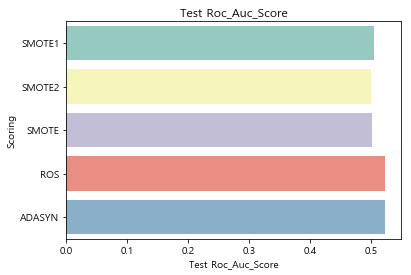

In [46]:
g = sns.barplot('test_roc_auc',"Scoring",data = oversampling, palette="Set3",orient = "h")
g.set_xlabel("Test Roc_Auc_Score")
g = g.set_title("Test Roc_Auc_Score")

# Under Sampling Mathod

In [47]:
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.ensemble import *
from imblearn.combine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score,accuracy_score

In [48]:
sampling = []
sampling.append(RandomUnderSampler(random_state=0))
sampling.append(CondensedNearestNeighbour(random_state=0))
sampling.append(EditedNearestNeighbours(random_state=0))
sampling.append(RepeatedEditedNearestNeighbours(random_state=0))
sampling.append(AllKNN(random_state=0))
sampling.append(InstanceHardnessThreshold(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(NearMiss(random_state=0,version=2))
sampling.append(NearMiss(random_state=0,version=3))
sampling.append(NeighbourhoodCleaningRule(random_state=0))
sampling.append(OneSidedSelection(random_state=0))
sampling.append(TomekLinks(random_state=0))
sampling.append(SMOTETomek(random_state=0, sampling_strategy='all'))
sampling.append(SMOTEENN(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

C:\Users\hyoun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class BalanceCascade is deprecated; BalanceCascade is deprecated in 0.4 and will be removed in 0.6.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\hyoun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class EasyEnsemble is deprecated; EasyEnsemble is deprecated in 0.4 and will be removed in 0.6. Use EasyEnsembleClassifier instead.
  warnings.warn(msg, category=DeprecationWarning)


In [49]:
data = pd.read_csv('WSDM_train_full_features.csv',engine='python')
data.head()

,target,user_idx,song_idx,ssn_idx,sst_idx,st_idx,song_length,genr_idx,art_idx,com_idx,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,1,0,0,0,0,0,206471,7,1877,7450,...,0,2,0,0,0,0,0,1,215,1140
1,1,1,1,1,1,1,284584,18,92,2,...,0,1,0,0,0,0,0,0,1,303616
2,1,1,2,1,1,1,225396,18,527,100234,...,0,1,0,0,0,0,0,1,4,289
3,1,1,3,1,1,1,255512,229,89592,193180,...,0,1,0,0,0,0,0,0,1,1
4,1,0,4,0,0,0,187802,13,195,137,...,0,3,0,0,0,0,0,1,412,427


In [50]:
from sklearn.model_selection import train_test_split
data,data_drop = train_test_split(data,test_size=0.15,random_state=0)
del data_drop # 삭제해서 용량 살리기 위해.

In [51]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

3113137

In [52]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
#target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/9)*len(target0)),:]

In [53]:
# 데이터 합치기 
data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
#data_0_1 = pd.concat([target1,target0_1])

In [54]:
X = data0_001.iloc[:,1:]
y = data0_001.iloc[:,0]

In [55]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

RandomUnderSampler

In [56]:
# 결과를 표로 정리하기 위한 리스트 
roc_auc = []
accuracy = []
f1 = []
preci = []
recall = []

In [57]:
X_tra,y_tra = sampling[0].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [58]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

accuracy_score 0.6483405285834699
f1_score 0.0027845521057037817
precision_score 0.0013961297701100479
recall_score 0.5043956043956044
roc_auc_score 0.6142638366509472


In [59]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Condensed Nearest Neighbours

In [60]:
X_tra,y_tra = sampling[1].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predictd(X_test)
y_proba = model.predict_proba(X_test)[:,1]

KeyboardInterrupt: 

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Edited Nearest Neighbours

In [ ]:
X_tra,y_tra = sampling[2].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Repeated Edited Nearest Neighbours

In [ ]:
X_tra,y_tra = sampling[3].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

All KNN

In [ ]:
X_tra,y_tra = sampling[4].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Instance Hardness Threshold

In [ ]:
X_tra,y_tra = sampling[5].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Near Miss version1

In [ ]:
X_tra,y_tra = sampling[6].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Near Miss version2

In [ ]:
X_tra,y_tra = sampling[7].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Near Miss version3

In [ ]:
X_tra,y_tra = sampling[8].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Neighbourhood Cleaning Rule

In [ ]:
X_tra,y_tra = sampling[9].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

One Sided Selection

In [ ]:
X_tra,y_tra = sampling[10].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Tomek Links

In [ ]:
X_tra,y_tra = sampling[11].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

# Combine under and over sampling

SMOTE Tomek

In [ ]:
X_tra,y_tra = sampling[12].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

SMOTE ENN

In [ ]:
X_tra,y_tra = sampling[13].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

# Ensanble

BalanceCascade

In [ ]:
X_tra,y_tra = sampling[14].fit_sample(X_train,y_train)
X_tra = X_tra.reshape(-1,29)
y_tra = y_tra.reshape(-1,1)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra[0],y_tra[0]).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Easy Ensemble

In [ ]:
X_tra,y_tra = sampling[15].fit_sample(X_train,y_train)
X_tra = X_tra.reshape(-1,29)
y_tra = y_tra.reshape(-1,1)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

In [ ]:
df = pd.DataFrame({'modelname':['RUS','CNN','ENN','RNN','AKNN','IHT','NMV1','NMV2',
                               'NMV3','NCR','OSS','TL','SMOT','SMOTNN','BC','EE'],
                  'roc_auc':roc_auc,'accuracy':accuracy,'f1_score':f1,'precision':preci,
                  'recall_score':recall})
df

# 그림그리기.

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 최고의 sampling model 선택

밑에서 4개 전까지는 UnderSampling
밑에서 2개 전까지는 combine
나머지 ensanble

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(AllKNN(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(TomekLinks(random_state=0))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

# 다른 imblanced에  최적의 모델 적용

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
#target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/9)*len(target0)),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
data0_01 = pd.concat([target0,target0_01])
#data_0_1 = pd.concat([target1,target0_1])
del target0, target0_01

In [ ]:
X = data0_01.iloc[:,1:]
y = data0_01.iloc[:,0]
del data0_01

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_1 = []
accuracy_1 = []
f1_1 = []
preci_1 = []
recall_1 = []

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_1.append(roc_auc_score(y_test,y_proba))
    accuracy_1.append(accuracy_score(y_test,y_pred))
    f1_1.append(f1_score(y_test,y_pred))
    preci_1.append(precision_score(y_test,y_pred))
    recall_1.append(recall_score(y_test,y_pred))

In [ ]:
df_1 = pd.DataFrame({'modelname':['SMOTE','AKNN','NM1','TL','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_1,'accuracy':accuracy_1,'f1_score':f1_1,'precision':preci_1,
                  'recall_score':recall_1})
df_1

# 결과 그리기

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 10% Imbalance 데이터 

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/9)*len(target0))),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
data0_10 = pd.concat([target0,target0_1])
del target0, target0_1

In [ ]:
X = data0_10.iloc[:,1:]
y = data0_10.iloc[:,0]
del data0_10

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_10 = []
accuracy_10 = []
f1_10 = []
preci_10 = []
recall_10 = []

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(AllKNN(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(TomekLinks(random_state=0))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_10.append(roc_auc_score(y_test,y_proba))
    accuracy_10.append(accuracy_score(y_test,y_pred))
    f1_10.append(f1_score(y_test,y_pred))
    preci_10.append(precision_score(y_test,y_pred))
    recall_10.append(recall_score(y_test,y_pred))

In [ ]:
df_10 = pd.DataFrame({'modelname':['SMOTE','AKNN','NM1','TL','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_10,'accuracy':accuracy_10,'f1_score':f1_10,'precision':preci_10,
                  'recall_score':recall_10})
df_10

# 결과 그리기

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 최고의 선정 모델 뽑기

In [ ]:
# 최적 모델 선정하기 
## 데이터를 분석하는 목적이 Recall을 줄이기 위한게 주 목적이다 -> Near Miss version1 을 이용하자.
## 데이터를 분석하는 목적이 Precision을 줄이기 위한것이 주 목적이다 -> AKNN을 이용하자. 
## 데이터를 분석할 때 F1_Score를 가지고 평가하는게 주 목적이다 -> Easy Eansanble을 이용하자. 

# 최고의 모델 ratio 바꿔가면서 진행

### 가장 성능이 잘나온 imblanced 데이터의 비율과 모델을 가지고 ratio를 변경하면서 시행

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(AllKNN(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(TomekLinks(random_state=0))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

# 20% Imbalance 데이터 

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/4)*len(target0))),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
data0_10 = pd.concat([target0,target0_1])
del target0, target0_1

In [ ]:
X = data0_10.iloc[:,1:]
y = data0_10.iloc[:,0]
del data0_10

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_20 = []
accuracy_20 = []
f1_20 = []
preci_20 = []
recall_20 = []

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_20.append(roc_auc_score(y_test,y_proba))
    accuracy_20.append(accuracy_score(y_test,y_pred))
    f1_20.append(f1_score(y_test,y_pred))
    preci_20.append(precision_score(y_test,y_pred))
    recall_20.append(recall_score(y_test,y_pred))

In [ ]:
df_20 = pd.DataFrame({'modelname':['SMOTE','AKNN','NM1','TL','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_20,'accuracy':accuracy_20,'f1_score':f1_20,'precision':preci_20,
                  'recall_score':recall_20})
df_20

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 25% Imbalance 데이터 

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(AllKNN(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(TomekLinks(random_state=0))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/3)*len(target0))),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
data0_10 = pd.concat([target0,target0_1])
del target0, target0_1

In [ ]:
X = data0_10.iloc[:,1:]
y = data0_10.iloc[:,0]
del data0_10

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_30 = []
accuracy_30 = []
f1_30 = []
preci_30 = []
recall_30 = []

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_30.append(roc_auc_score(y_test,y_proba))
    accuracy_30.append(accuracy_score(y_test,y_pred))
    f1_30.append(f1_score(y_test,y_pred))
    preci_30.append(precision_score(y_test,y_pred))
    recall_30.append(recall_score(y_test,y_pred))

In [ ]:
df_30 = pd.DataFrame({'modelname':['SMOTE','AKNN','NM1','TL','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_30,'accuracy':accuracy_30,'f1_score':f1_30,'precision':preci_30,
                  'recall_score':recall_30})
df_30

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 7% 코드
# 30~40만개 코드

In [ ]:
data = pd.read_csv('WSDM_train_full_features.csv',engine='python')
data.head()

In [ ]:
from sklearn.model_selection import train_test_split
data,data_drop = train_test_split(data,test_size=0.93,random_state=0)
del data_drop # 삭제해서 용량 살리기 위해.

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
#target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/9)*len(target0)),:]

In [ ]:
# 데이터 합치기 
data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
#data_0_1 = pd.concat([target1,target0_1])
del target0, target0_001

In [ ]:
X = data0_001.iloc[:,1:]
y = data0_001.iloc[:,0]
del data0_001

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.ensemble import *
from imblearn.combine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score,accuracy_score

In [ ]:
# Over sampling model  
# ratio
sampling = []
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline1'))
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline2'))
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(RandomOverSampler(random_state=0))
sampling.append(ADASYN(random_state=0))
# Under sampling model 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score,accuracy_score

In [ ]:
roc_auc_10 = []
accuracy_10 = []
f1_10 = []
preci_10 = []
recall_10 = []

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_10.append(roc_auc_score(y_test,y_proba))
    accuracy_10.append(accuracy_score(y_test,y_pred))
    f1_10.append(f1_score(y_test,y_pred))
    preci_10.append(precision_score(y_test,y_pred))
    recall_10.append(recall_score(y_test,y_pred))

In [ ]:
df_1 = pd.DataFrame({'modelname':['SMOTE1','SMOTE2','SMOTE','ROS','ADASYN'],
                  'roc_auc':roc_auc_10,'accuracy':accuracy_10,'f1_score':f1_10,'precision':preci_10,
                  'recall_score':recall_10})
df_1

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

In [ ]:
#under
sampling = []
sampling.append(RandomUnderSampler(random_state=0))
sampling.append(CondensedNearestNeighbour(random_state=0))
sampling.append(EditedNearestNeighbours(random_state=0))
sampling.append(RepeatedEditedNearestNeighbours(random_state=0))
sampling.append(AllKNN(random_state=0))
sampling.append(InstanceHardnessThreshold(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(NearMiss(random_state=0,version=2))
sampling.append(NearMiss(random_state=0,version=3))
sampling.append(NeighbourhoodCleaningRule(random_state=0))
sampling.append(OneSidedSelection(random_state=0))
sampling.append(TomekLinks(random_state=0))
#over
sampling.append(RandomOverSampler(random_state=0))
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline1'))
sampling.append(SMOTE(random_state=0,k_neighbors=5,kind='borderline2'))
sampling.append(ADASYN(random_state=0))
# cobine under and over sampling
# ratio 
sampling.append(SMOTETomek(random_state=0, sampling_strategy='all'))
sampling.append(SMOTEENN(random_state=0))
# ensanble
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

# Under Sampling Mathod

RandomUnderSampler

In [ ]:
# 결과를 표로 정리하기 위한 리스트 
roc_auc = []
accuracy = []
f1 = []
preci = []
recall = []

In [ ]:
X_tra,y_tra = sampling[0].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Condensed Nearest Neighbours

In [ ]:
X_tra,y_tra = sampling[1].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Edited Nearest Neighbours

In [ ]:
X_tra,y_tra = sampling[2].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Repeated Edited Nearest Neighbours

In [ ]:
X_tra,y_tra = sampling[3].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

All KNN

In [ ]:
X_tra,y_tra = sampling[4].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Instance Hardness Threshold

In [ ]:
X_tra,y_tra = sampling[5].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Near Miss version1

In [ ]:
X_tra,y_tra = sampling[6].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Near Miss version2

In [ ]:
X_tra,y_tra = sampling[7].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Near Miss version3

In [ ]:
X_tra,y_tra = sampling[8].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Neighbourhood Cleaning Rule

In [ ]:
X_tra,y_tra = sampling[9].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

One Sided Selection

In [ ]:
X_tra,y_tra = sampling[10].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Tomek Links

In [ ]:
X_tra,y_tra = sampling[11].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

# Combine under and over sampling

SMOTE Tomek

In [ ]:
X_tra,y_tra = sampling[12].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

SMOTE ENN

In [ ]:
X_tra,y_tra = sampling[13].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

# Ensanble

BalanceCascade

In [ ]:
X_tra,y_tra = sampling[14].fit_sample(X_train,y_train)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra[0],y_tra[0]).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

Easy Ensemble

In [ ]:
X_tra,y_tra = sampling[15].fit_sample(X_train,y_train)
X_tra = X_tra.reshape(-1,29)
y_tra = y_tra.reshape(-1,1)
model = RandomForestClassifier(random_state=0)
y_pred = model.fit(X_tra,y_tra).predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [ ]:
X_tra,y_tra = sampling[15].fit_sample(X_train,y_train)
X_tra = X_tra.reshape(-1,29)
display(len(X_tra))
display(len(y_tra))

In [ ]:
print('accuracy_score',accuracy_score(y_test,y_pred))
print('f1_score',f1_score(y_test,y_pred))
print('precision_score',precision_score(y_test,y_pred))
print('recall_score',recall_score(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_proba))

In [ ]:
roc_auc.append(roc_auc_score(y_test,y_proba))
accuracy.append(accuracy_score(y_test,y_pred))
f1.append(f1_score(y_test,y_pred))
preci.append(precision_score(y_test,y_pred))
recall.append(recall_score(y_test,y_pred))

In [ ]:
df = pd.DataFrame({'modelname':['RUS','CNN','ENN','RNN','AKNN','IHT','NMV1','NMV2',
                               'NMV3','NCR','OSS','TL','SMOT','SMOTNN','BC','EE'],
                  'roc_auc':roc_auc,'accuracy':accuracy,'f1_score':f1,'precision':preci,
                  'recall_score':recall})
df

# 그림그리기.

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 최고의 sampling model 선택

밑에서 4개 전까지는 UnderSampling
밑에서 2개 전까지는 combine
나머지 ensanble

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(RandomUnderSampler(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(NearMiss(random_state=0,version=3))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

# 다른 imblanced에  최적의 모델 적용

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
#target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/9)*len(target0)),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
data0_01 = pd.concat([target0,target0_01])
#data_0_1 = pd.concat([target1,target0_1])
del target0, target0_01

In [ ]:
X = data0_01.iloc[:,1:]
y = data0_01.iloc[:,0]
del data0_01

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_1 = []
accuracy_1 = []
f1_1 = []
preci_1 = []
recall_1 = []

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_1.append(roc_auc_score(y_test,y_proba))
    accuracy_1.append(accuracy_score(y_test,y_pred))
    f1_1.append(f1_score(y_test,y_pred))
    preci_1.append(precision_score(y_test,y_pred))
    recall_1.append(recall_score(y_test,y_pred))

In [ ]:
df_1 = pd.DataFrame({'modelname':['SMOTE','RUS','NM1','NM3','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_1,'accuracy':accuracy_1,'f1_score':f1_1,'precision':preci_1,
                  'recall_score':recall_1})
df_1

# 결과 그리기

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_1, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 10% Imbalance 데이터 

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/9)*len(target0))),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
data0_10 = pd.concat([target0,target0_1])
del target0, target0_1

In [ ]:
X = data0_10.iloc[:,1:]
y = data0_10.iloc[:,0]
del data0_10

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_10 = []
accuracy_10 = []
f1_10 = []
preci_10 = []
recall_10 = []

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(RandomUnderSampler(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(NearMiss(random_state=0,version=3))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_10.append(roc_auc_score(y_test,y_proba))
    accuracy_10.append(accuracy_score(y_test,y_pred))
    f1_10.append(f1_score(y_test,y_pred))
    preci_10.append(precision_score(y_test,y_pred))
    recall_10.append(recall_score(y_test,y_pred))

In [ ]:
df_10 = pd.DataFrame({'modelname':['SMOTE','RUS','NM1','NM3','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_10,'accuracy':accuracy_10,'f1_score':f1_10,'precision':preci_10,
                  'recall_score':recall_10})
df_10

# 결과 그리기

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_10, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

### 가장 성능이 잘나온 imblanced 데이터의 비율과 모델을 가지고 ratio를 변경하면서 시행

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(RandomUnderSampler(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(NearMiss(random_state=0,version=3))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

# 20% Imbalance 데이터 

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/4)*len(target0))),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
data0_10 = pd.concat([target0,target0_1])
del target0, target0_1

In [ ]:
X = data0_10.iloc[:,1:]
y = data0_10.iloc[:,0]
del data0_10

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_20 = []
accuracy_20 = []
f1_20 = []
preci_20 = []
recall_20 = []

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_20.append(roc_auc_score(y_test,y_proba))
    accuracy_20.append(accuracy_score(y_test,y_pred))
    f1_20.append(f1_score(y_test,y_pred))
    preci_20.append(precision_score(y_test,y_pred))
    recall_20.append(recall_score(y_test,y_pred))

In [ ]:
df_20 = pd.DataFrame({'modelname':['SMOTE','RUS','NM1','NM3','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_20,'accuracy':accuracy_20,'f1_score':f1_20,'precision':preci_20,
                  'recall_score':recall_20})
df_20

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_20, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")

# 25% Imbalance 데이터 

In [ ]:
sampling = []
# OverSampling Method
sampling.append(SMOTE(random_state=0,k_neighbors=5))
sampling.append(RandomUnderSampler(random_state=0))
sampling.append(NearMiss(random_state=0,version=1))
sampling.append(NearMiss(random_state=0,version=3))
sampling.append(SMOTETomek(random_state=0))
sampling.append(BalanceCascade(random_state=0))
sampling.append(EasyEnsemble(random_state=0))

In [ ]:
target1 = data[data['target']==1]
target0 = data[data['target']==0] # 비율 구하기 위해 사용 
len(target0)

In [ ]:
# target 값이 1일때 전체 데이터에 대한 비율에 맞춰 추출하기 
# 용량을 너무 많이 차지해서 한개씩 실행해야 한다. 
np.random.seed(0) # 난수고정 
#target0_001 = target1.iloc[np.random.randint(0,len(target1),size=round((1/999)*len(target0))),:]
#target0_01 = target1.iloc[np.random.randint(0,len(target1),size=round((1/99)*len(target0))),:]
target0_1 = target1.iloc[np.random.randint(0,len(target1),size=round((1/3)*len(target0))),:]

In [ ]:
# 데이터 합치기 
#data0_001 = pd.concat([target0,target0_001])
#data0_01 = pd.concat([target0,target0_01])
data0_10 = pd.concat([target0,target0_1])
del target0, target0_1

In [ ]:
X = data0_10.iloc[:,1:]
y = data0_10.iloc[:,0]
del data0_10

In [ ]:
# train data, test data 분할하기. 
X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
roc_auc_30 = []
accuracy_30 = []
f1_30 = []
preci_30 = []
recall_30 = []

In [ ]:
for i in range(len(sampling)):
    model = RandomForestClassifier(random_state=0)
    X_tra,y_tra = sampling[i].fit_sample(X_train,y_train)
    X_tra = X_tra.reshape(-1,29)
    y_tra = y_tra.reshape(-1,1)
    y_pred = model.fit(X_tra,y_tra).predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc_30.append(roc_auc_score(y_test,y_proba))
    accuracy_30.append(accuracy_score(y_test,y_pred))
    f1_30.append(f1_score(y_test,y_pred))
    preci_30.append(precision_score(y_test,y_pred))
    recall_30.append(recall_score(y_test,y_pred))

In [ ]:
df_30 = pd.DataFrame({'modelname':['SMOTE','RUS','NM1','NM3','SMOT','BC','EE' ],
                  'roc_auc':roc_auc_30,'accuracy':accuracy_30,'f1_score':f1_30,'precision':preci_30,
                  'recall_score':recall_30})
df_30

In [ ]:
g = sns.barplot("roc_auc","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Roc_Auc_Score")
g = g.set_title("Roc_Auc_Score")

In [ ]:
g = sns.barplot("accuracy","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Accuracy_Score")
g = g.set_title("Accuracy_Score")

In [ ]:
g = sns.barplot("f1_score","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("F1_Score")
g = g.set_title("F1_Score")

In [ ]:
g = sns.barplot("precision","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Precision_Score")
g = g.set_title("Precision_Score")

In [ ]:
g = sns.barplot("recall_score","modelname",data = df_30, palette="Set3",orient = "h")
g.set_xlabel("Recall_Score")
g = g.set_title("Recall_Score")